[IGRA (Integrated Global Radiosonde Archive) data](https://www1.ncdc.noaa.gov/pub/data/igra/)

In [1]:
import sys, re
sys.path.append('../python/')
from data.IGRA import Monthly
from data.NCDC import GHCND
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs
from plots import annotated, availability_matrix as avail

In [2]:
%matplotlib nbagg

In [3]:
def set_logic(a, b):
    a, b = a.dropna(), b.dropna()
    i = a.index.intersection(b.index)
    return a.loc[a.index.difference(i)], b.loc[b.index.difference(i)], a.loc[i]

## Stations

In [35]:
# IGRA (radiosonde archive)
ista = Monthly.read_stations('../../data/IGRA/igra2-station-list.txt').query('lat<=-60')

# READER (BAS) and NCDC
with pd.HDFStore('../../data/Antarctica/stations.h5') as S:
    sta = S['sta']

In [9]:
ista.loc[89611]

id            AYM00089611
lat              -66.2825
lon               110.523
elev                   40
state                 NaN
name                CASEY
first_year           1957
last_year            2017
nobs                39636
Name: 89611, dtype: object

### NCDC vs READER stations

<IPython.core.display.Javascript object>


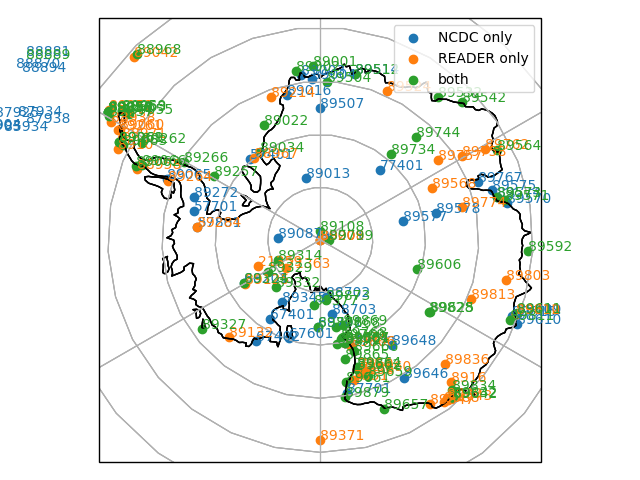

In [170]:
ncdc_sta, read_sta, both_sta = set_logic(sta[['longitude', 'latitude']], sta[['Longitude', 'Latitude']])

plt.figure()
ax = plt.axes(projection=crs.SouthPolarStereo())

plt.legend([annotated(ncdc_sta), annotated(read_sta), annotated(both_sta)],
    ['NCDC only', 'READER only', 'both'])

plt.tight_layout()

In [4]:
with pd.HDFStore('../../data/Antarctica/READER.h5') as S:
    reader = pd.concat((S['sfc'], S['aws']), 1)
    # drop station with less than 12 months of data
    reader.drop(
        (reader.groupby(axis=1, level=0).apply(lambda x:x.count().max()) < 12).replace(False, float('nan')).dropna().index,
        1, 0, inplace=True
    )

In [76]:
from geo import box

In [77]:
w = set(z[0] for z in filter(lambda s:re.search('wind', s[1]), reader.columns.tolist()))

<IPython.core.display.Javascript object>


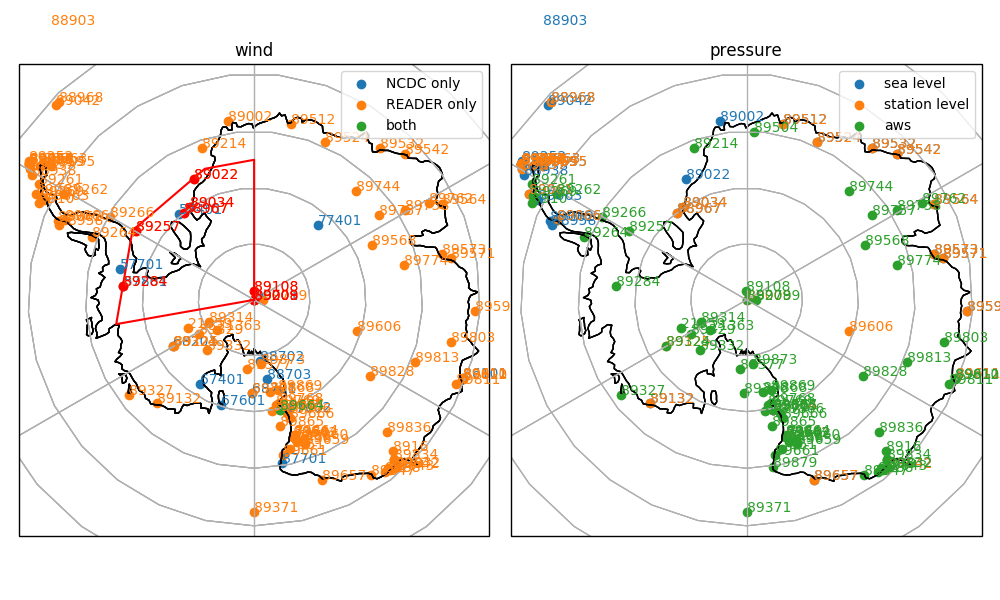

In [81]:
wab = box(-100, 0, -90, -75)

ncdc_wind, read_wind, both_wind = set_logic(
    sta[sta.WIND==True][['longitude', 'latitude']],
    sta.loc[w][['Longitude', 'Latitude']]
)

fig, axs = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': crs.SouthPolarStereo()})

axs[0].legend([annotated(ncdc_wind, axs[0]), annotated(read_wind, axs[0]), annotated(both_wind, axs[0])],
           ['NCDC only', 'READER only', 'both'])
axs[0].set_title('wind')
axs[0].plot(*wab.rect, color='r', transform=crs.PlateCarree())
annotated(wab.stations(sta, 'Longitude', 'Latitude'), axs[0], 'r')

ll = ['Longitude', 'Latitude']
axs[1].legend(
    [annotated(sta.loc[reader.xs(s, 1, 1).dropna(0, 'all').columns.get_level_values(0).unique(), ll], axs[1])
     for s in ['msl_pressure', 'station_level_pressure', 'pressure']],
    ['sea level', 'station level', 'aws'])
axs[1].set_title('pressure')

plt.tight_layout()

In [139]:
m = reader.xs('wind_direction', 1, 1).groupby(axis=1,level=0).apply(lambda g:g.sum(1)).dropna(0, 'all').notnull()
b = np.where(m.columns.isin(wab.stations(sta, 'Longitude', 'Latitude').index))[0]
c = np.where(sta.loc[m.columns]['type'].str.contains('sfc'))[0] # includes 'sfc+aws'
m.columns = ['{} - {}'.format(s[1], s[0]) for s in sta.loc[m.columns]['Name'].iteritems()]

In [121]:
from spatial_stats import Blocks
from sklearn.tree import DecisionTreeClassifier
B = Blocks(DecisionTreeClassifier, min_samples_leaf=36)
B.compute(m.replace(False, np.nan))

In [125]:
B.compute(m.replace(False, np.nan))

<IPython.core.display.Javascript object>


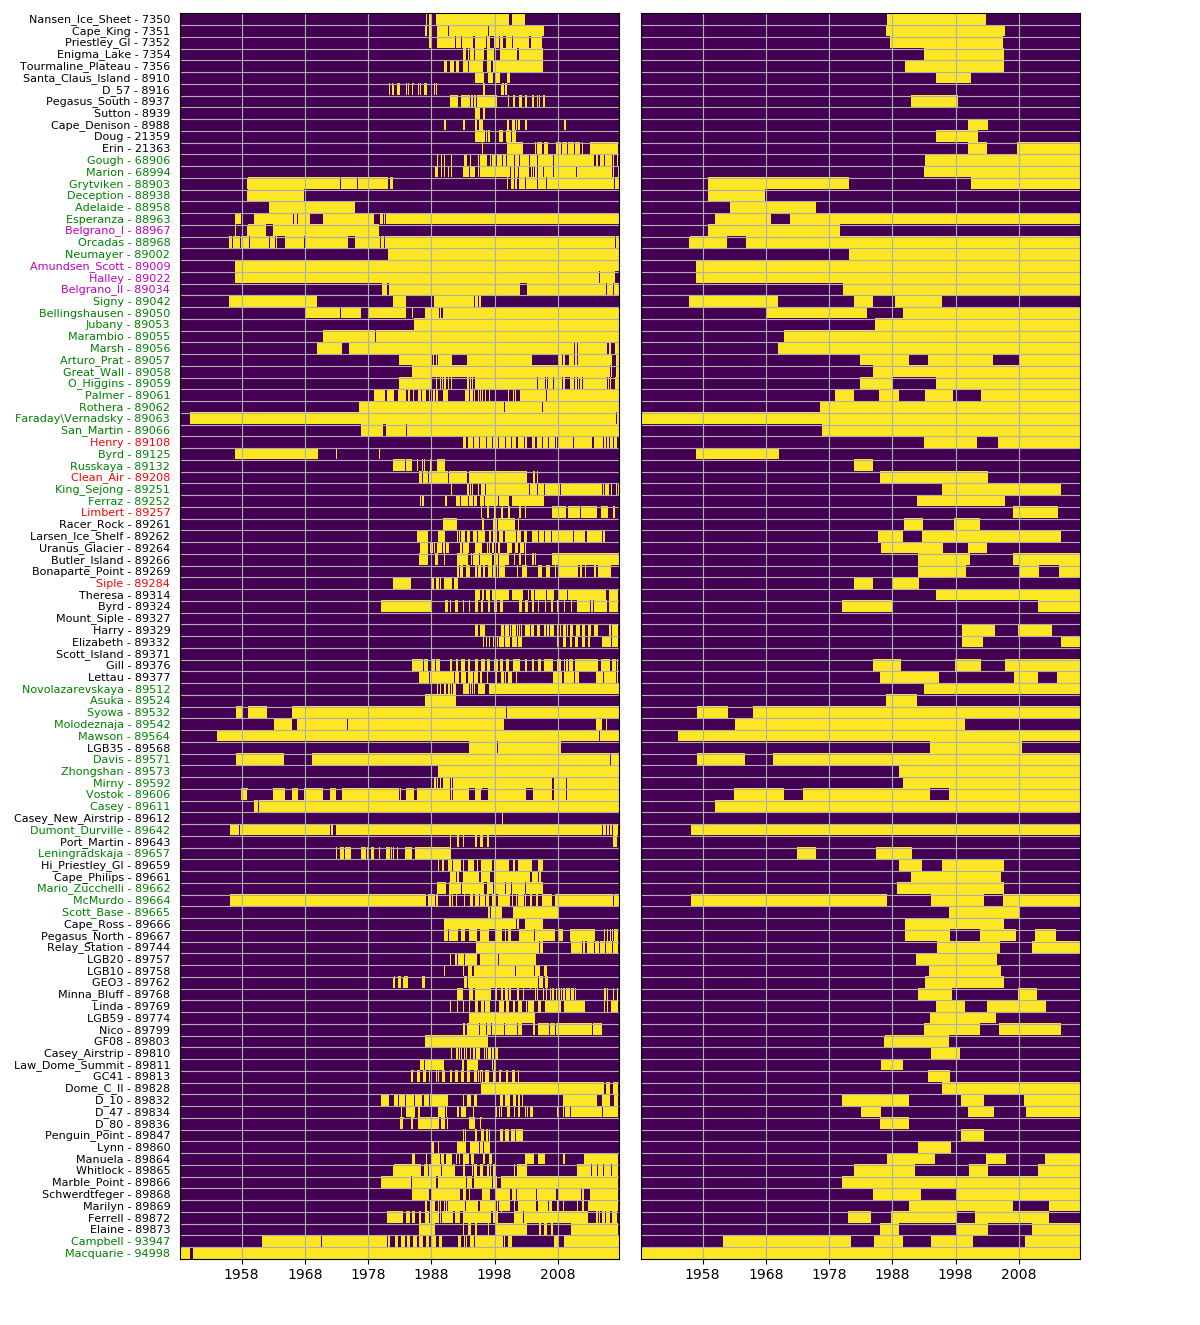

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(12, 0.125*m.shape[1]))
avail(m, left=.15, ax=axs[0],
                       color={'r':set(b)-set(c), 'g':set(c)-set(b), 'm':set(c).intersection(b)})
avail(B.check().astype(float), ax=axs[1], label=False, wspace=.05)

In [151]:
sta.loc[sta.Name.str.contains('Limbert').fillna(False)]

,COMP,Height,Latitude,Longitude,MISC,Name,PRCP,SKY,SUN,TEMP,...,datacoverage,elevation,elevationUnit,id,latitude,longitude,maxdate,mindate,name,type
89257,False,40.0,-75.4,-59.9,False,Limbert,False,False,False,True,...,0.8376,40.0,METERS,GHCND:AYM00089257,-75.867,-59.15,2014-05-19,1998-03-01,UNIVERSITY WI ID 8925 LIMBERT AWS,aws


In [159]:
ncdc = GHCND('../../data/NCDC/ghcnd_all.tar.gz')
x = ncdc.data(89257).sel(field='TAVG', flag='value').resample('MS', 'time', how='mean')

<IPython.core.display.Javascript object>


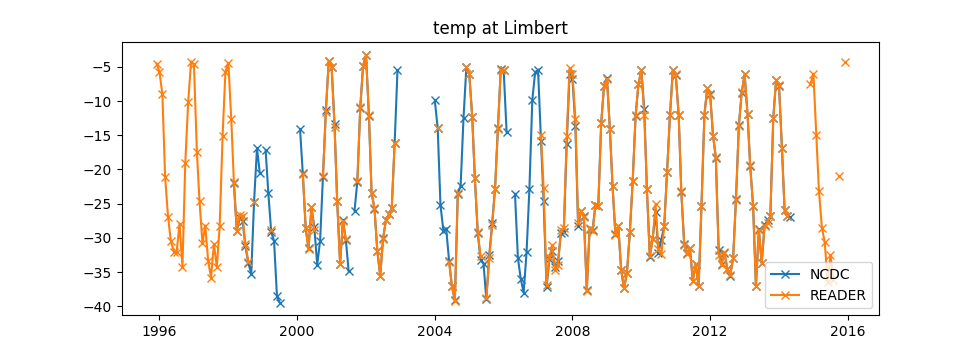

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [177]:
plt.figure()
plt.plot(x.time, x/10, 'x-', label='NCDC')
plt.plot(reader[(89257, 'temperature', 'All')], 'x-', label='READER')
plt.title('temp at Limbert')
plt.legend();

Temperature records seem to match between NCDC and READER databases, at Limbert. **NCDC** has:
- **daily** records
- more temporal **coverage**

### IGRA vs READER upper air stations

In [24]:
ua = xr.open_dataarray('../../data/Antarctica/READER_upper_atmos.nc')

<IPython.core.display.Javascript object>


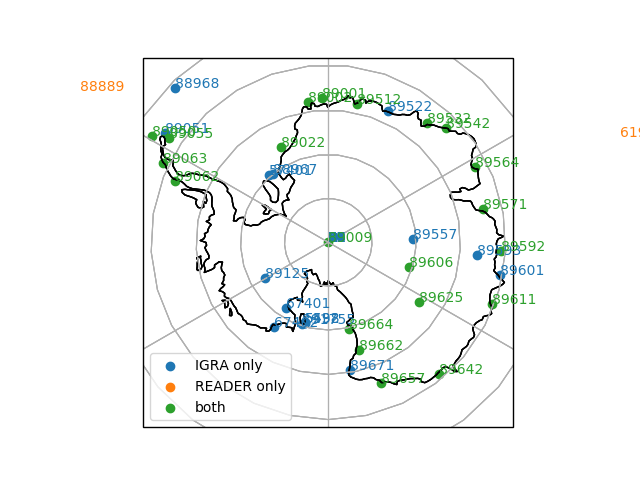

In [207]:
ista_only, read_only, both = set_logic(ista[['lon', 'lat']], sta.loc[ua.station, ['Longitude', 'Latitude']])

plt.figure()
ax = plt.subplot(1, 1, 1, projection=crs.SouthPolarStereo())
plt.legend([annotated(ista_only), annotated(read_only), annotated(both)],
          ['IGRA only', 'READER only', 'both'])

In [208]:
sta.loc[89611]

COMP                          True
Height                          42
Latitude                     -66.3
Longitude                    110.5
MISC                          True
Name                         Casey
PRCP                          True
SKY                          False
SUN                          False
TEMP                          True
WATER                        False
WIND                         False
WXTYPE                       False
datacoverage                     1
elevation                       41
elevationUnit               METERS
id               GHCND:AYM00089611
latitude                   -66.283
longitude                  110.517
maxdate                 2017-09-30
mindate                 1969-03-01
name                         CASEY
type                           sfc
Name: 89611, dtype: object

In [2]:
mly = Monthly.tar_to_xarray('../../data/IGRA/IGRA-mly.tar.gz', ['AYM00089611'], tar=re.compile('temp'))

In [21]:
x = mly.data['temp'].sel(type='value', lvl=850).resample('MS', 'time', how='mean').squeeze()
y = ua.sel(station=89611, lvl='850', var='temperature').squeeze()

<IPython.core.display.Javascript object>


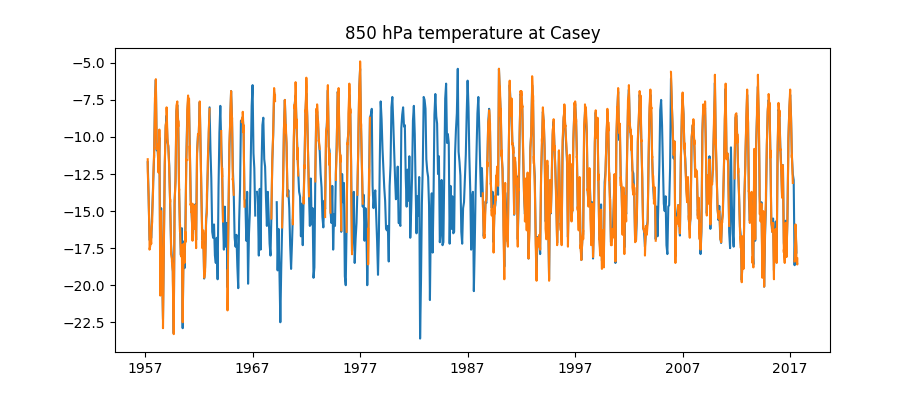

In [33]:
plt.figure()
plt.plot(x.time, x/10, label='IGRA')
plt.plot(y.time, y, label='READER')
plt.title('850 hPa temperature at Casey')

IGRA and READER data appear to match for 850 hPa at Casey (longest record), but **IRGRA**:
- has **daily** data (in principle, availability not checked yet)
- seems to have more **coverage**
- has **more** stations listed
- all stations that only appear in READER database are north of ~55 S (not checked for what data is available at listed IGRA stations) 